#### library

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np

# visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# warning
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# statsmodel
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.multivariate.manova import MANOVA


# model
import lightgbm as lgb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim


print(torch.__version__)

2.4.1+cu121


#### data load

In [4]:
# 파일 호출
data_path: str = "../../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [5]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 39.01it/s]


### EDA

#### baseline feature engineering

In [15]:
eda_df = df.loc[df["_type"] == "train"]

In [5]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 19)

In [6]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [7]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [8]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)
df.head(3)

,ID,target,_type,coinbase_premium_gap,coinbase_premium_index,funding_rates,long_liquidations,long_liquidations_usd,short_liquidations,short_liquidations_usd,...,volume_diff_14,volume_diff_15,volume_diff_16,volume_diff_17,volume_diff_18,volume_diff_19,volume_diff_20,volume_diff_21,volume_diff_22,volume_diff_23
0,2023-01-01 00:00:00,2.0,train,-9.86,-0.059650,0.005049,0.012,197.5161,0.000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,1.0,train,-8.78,-0.053047,0.005049,0.000,0.0000,0.712,11833.56104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00,1.0,train,-9.59,-0.057952,0.005049,0.000,0.0000,0.000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
missing_values

ID                           0
target                    2792
_type                        0
coinbase_premium_gap         6
coinbase_premium_index       6
                          ... 
volume_diff_19              31
volume_diff_20              31
volume_diff_21              31
volume_diff_22              31
volume_diff_23              31
Length: 486, dtype: int64

In [ ]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

* 애초에 df에서 list로 할당된 변수들만 사용했음
* 때문에 해당 값들은 결측치가 거의 없음
* 종가에 대한 데이터에 관련하여 변수추가를 진행함(진경이 데이터엔)
* 종가의 거래량과 관련하여 변수추가도 고려해볼 필요가 있음

#### new engineering

1. elasticnet을 통한 변수 추출

In [21]:
# missing value check

train_df = eda_df.copy()
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [22]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)
new_train_df.head(3)

,ID,target,_type,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,...,197.5161,0.00000,3.412540e+07,37752,0.561037,9271.503609,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,1.0,train,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,...,0.0000,11833.56104,3.456750e+07,20534,0.256248,4237.095391,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,1.0,train,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,...,0.0000,0.00000,3.452090e+07,19369,0.312978,5176.614029,0.0,0.0,0.0,0.0


In [30]:
# 데이터프레임에서 입력 데이터(X)와 타겟 변수(y)로 분리
X = new_train_df.drop(columns=['target','ID','_type'])  # 'target'은 예측하려는 클래스
y = new_train_df['target']

# 2. 학습 데이터와 테스트 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

# 3. 데이터 스케일링 (ElasticNet은 데이터 스케일에 민감하기 때문에 필요)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_valid)

# 4. ElasticNet 모델 설정 및 학습
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# 5. 학습된 모델을 사용해 중요 변수 추출
# ElasticNet은 불필요한 변수의 계수를 0으로 만드므로, 중요 변수를 확인할 수 있음
coefficients = elastic_net.coef_

# 6. 피처 중요도 출력 (가중치가 0이 아닌 변수만 선택)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# 가중치가 0이 아닌 변수만 선택
important_features = feature_importance[feature_importance['Coefficient'] != 0]
important_features = important_features.sort_values(by='Coefficient', ascending=False)

print("Selected Important Features:")
print(important_features)

212

모든 column에 대해 유의미하지 않다고 결과가 나옴

2. test에서 missing 100%인 데이터 모두 예측

In [32]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_train_df[col]).any()) | (np.isinf(new_train_df[col]).any()):
        print(col)
        break

In [33]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

In [39]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [47]:
columns_with_all_missing_usd = [col for col in columns_with_all_missing if 'liquidations_usd' in col]
columns_with_all_missing = [col for col in columns_with_all_missing if 'liquidations_usd'  not in col]


In [43]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing_usd, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing_usd, errors='ignore')

In [44]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [45]:
# Standardization으로 정규화
from sklearn.preprocessing import StandardScaler

def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

나머지 변수 예측 및 결측치 처리 진행

In [48]:
std_train_df_imp = std_train_df.copy()
std_test_df_imp = std_test_df.copy()

In [49]:
# usd에 해당되는 변수는 제거하고 사용
def random_forest_reg_with_col(train_data ,test_data, column):
    y_train = train_data[col]
    X_train = train_data.drop(columns=[col, 'ID', 'target', '_type'], errors='ignore')

    # 훈련 데이터와 검증 데이터 나누기
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.2, random_state=42)

    # 모델 훈련
    model = RandomForestRegressor()
    model.fit(X_train_split, y_train_split)

    # 검증 데이터에서 예측
    y_val_pred = model.predict(X_val)

    # 성능 평가
    mse = mean_squared_error(y_val, y_val_pred)

    # 전체 데이터에 대한 모델 훈련
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # test_df에서 예측
    X_test = test_data.drop(columns=[col, 'ID', 'target', '_type'], errors='ignore')
    y_pred = model.predict(X_test)

    return y_pred

In [ ]:
# 너무 오래걸린다
for col in columns_with_all_missing:
    y_predict = random_forest_reg_with_col(std_train_df_imp, std_test_df_imp, col)
    std_test_df[col] = y_predict
    print(f'{col} train finish')

In [ ]:
std_test_df.head(3)

In [ ]:
std_train_df[columns_with_all_missing[0]]

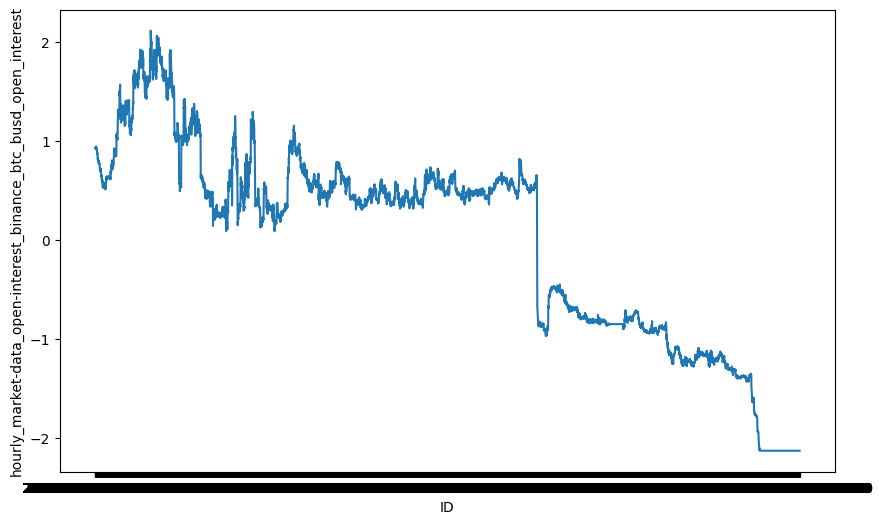

In [56]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[0])
plt.show()

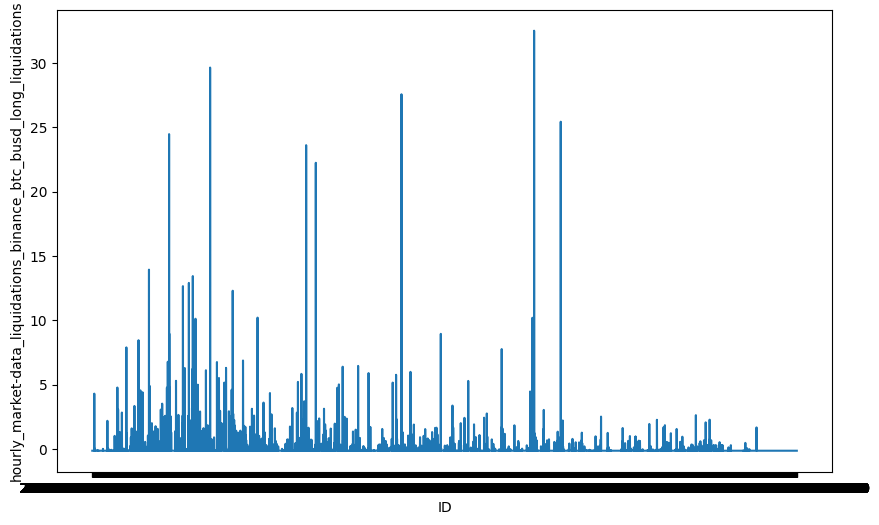

In [57]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[1])
plt.show()

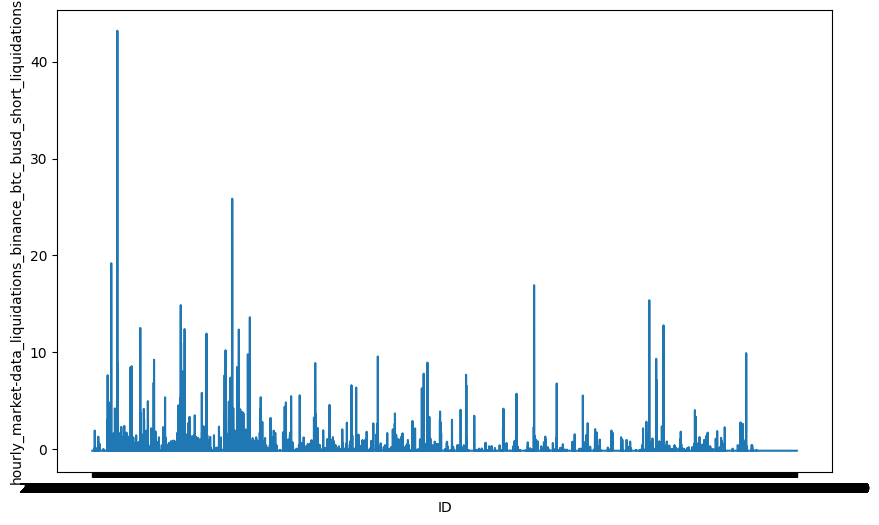

In [58]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[2])
plt.show()

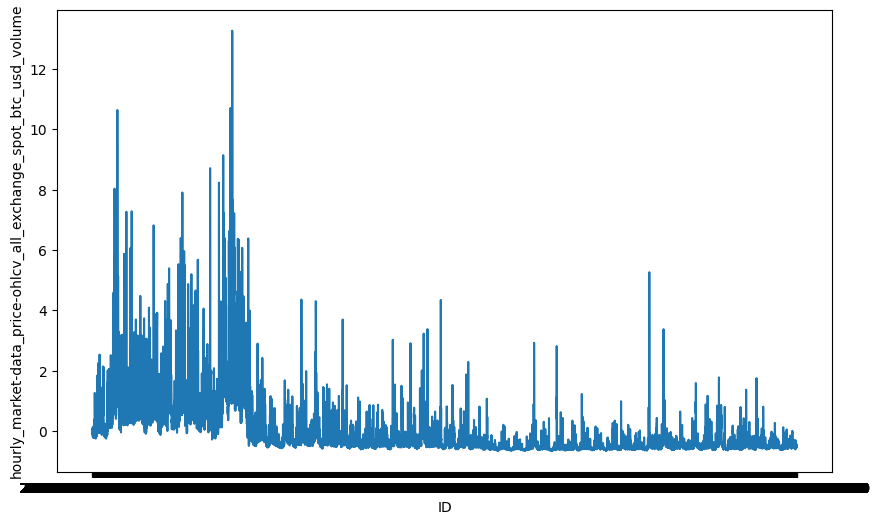

In [59]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[3])
plt.show()

### After

In [6]:
# missing value check

train_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [7]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

In [9]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

In [10]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [11]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing, errors='ignore')

In [12]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [13]:
def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

In [14]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train_split, y_train_split)

# 검증 데이터에서 예측
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = y_pred

Mean Squared Error on Validation Set: 0.0006581738329008575


In [86]:
df = pd.concat([std_train_df, std_test_df], ignore_index=True)

In [87]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close" : "close",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 20)

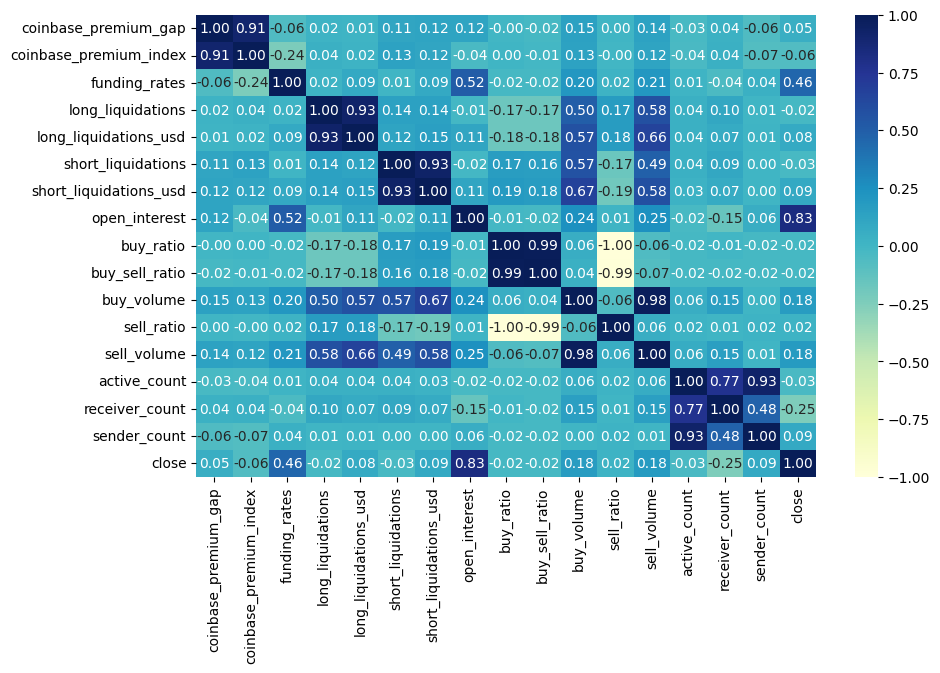

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(df.iloc[:,3:].corr(), annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

In [25]:
corr_df = df.iloc[:,3:]

# VIF 계산 함수
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    
    # VIF 계산
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# VIF 값 계산
vif_data = calculate_vif(corr_df)
vif_data.sort_values(by="VIF", ascending=False, inplace=True)

# VIF 10을 초과하는 컬럼 필터링
high_vif = vif_data[vif_data["VIF"] > 10]

# 상관관계 계산
correlations = corr_df.corr()

# VIF 10 이상인 컬럼 간 상관관계 및 VIF 값으로 새로운 데이터프레임 생성
results = []

# VIF 10 이상인 각 컬럼에 대해 상관관계와 VIF 값 추출
for i, col1 in enumerate(high_vif['Feature']):
    for col2 in high_vif['Feature'][i+1:]:
        corr_value = correlations.loc[col1, col2]
        vif_value1 = high_vif[high_vif['Feature'] == col1]['VIF'].values[0]
        vif_value2 = high_vif[high_vif['Feature'] == col2]['VIF'].values[0]
        results.append({'Column1': f'{col1}', 'Column2' : f'{col2}', 'Correlation': corr_value, 'VIF': max(vif_value1, vif_value2)})

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(results)
result_df

,Column1,Column2,Correlation,VIF
0,buy_ratio,sell_ratio,-1.000000,inf
1,buy_ratio,active_count,-0.016834,inf
2,buy_ratio,sender_count,-0.018959,inf
3,buy_ratio,sell_volume,-0.055593,inf
4,buy_ratio,buy_volume,0.058658,inf
5,buy_ratio,receiver_count,-0.006470,inf
6,buy_ratio,buy_sell_ratio,0.989207,inf
7,buy_ratio,short_liquidations_usd,0.188180,inf
8,buy_ratio,long_liquidations_usd,-0.175903,inf
9,sell_ratio,active_count,0.016834,inf


상관관계가 높은 변수끼린 하나씩 제거함  
1. buy_ratio와 sell_ratio 제거 -> buy-sell-ratio만 살려둠  
2. used가 들어간 liquidation은 제거  
3. buy or sell volume은 buy쪽만 살려둠  
4. active or sender count도 active만 살려둠

In [88]:
final_df = df.copy()
final_df = final_df.drop(columns = ['long_liquidations_usd','short_liquidations_usd','buy_ratio','sell_ratio','sell_ratio','sender_count'])
final_df.columns

Index(['ID', 'target', '_type', 'coinbase_premium_gap',
       'coinbase_premium_index', 'funding_rates', 'long_liquidations',
       'short_liquidations', 'open_interest', 'buy_sell_ratio', 'buy_volume',
       'sell_volume', 'active_count', 'receiver_count', 'close'],
      dtype='object')

In [89]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
    close_diff = df['close'].diff().fillna(0),
    close_diffg = np.sign(df['close'].diff().fillna(0))
)
df.shape

(11552, 29)

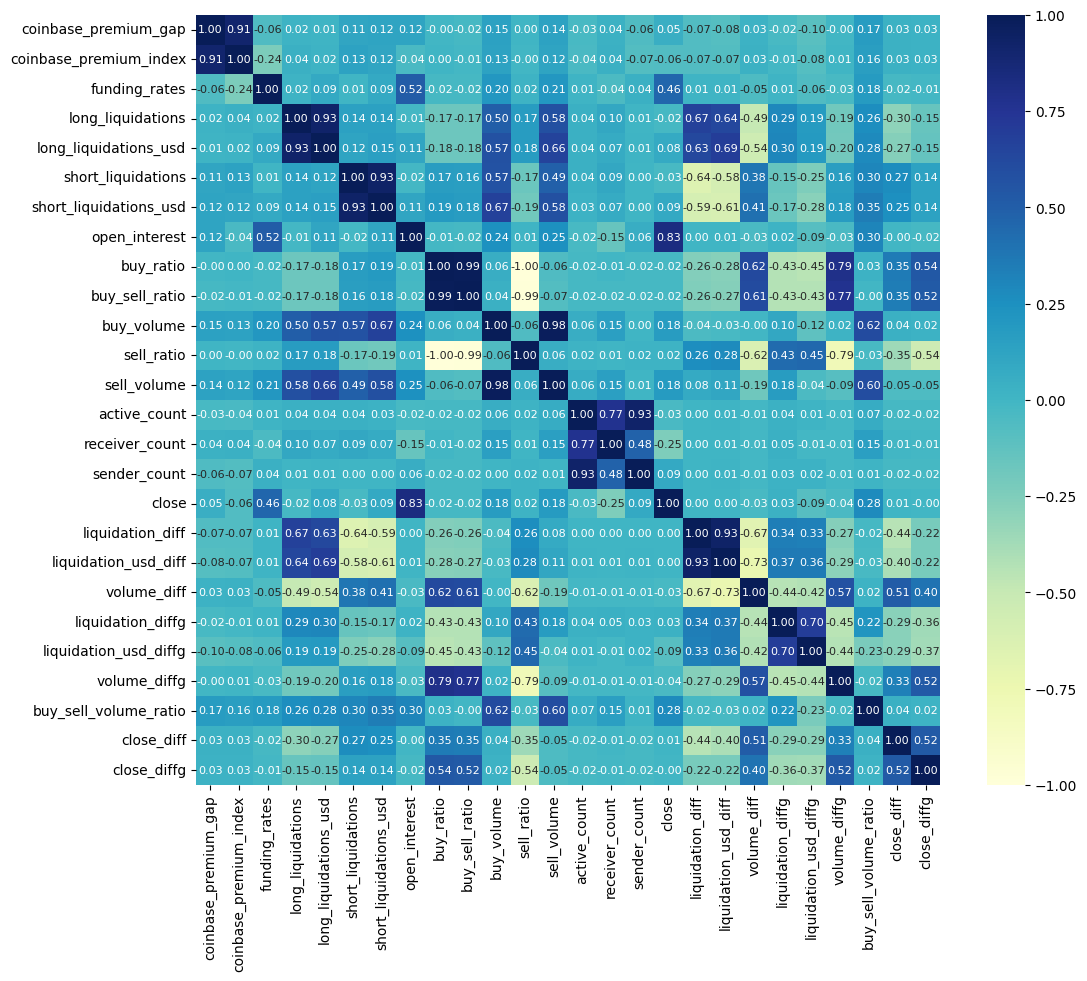

In [31]:
plt.figure(figsize=(12,10))
sns.heatmap(df.iloc[:,3:].corr(), annot=True, fmt=".2f", cmap="YlGnBu", annot_kws={"size": 8})
plt.show()

In [90]:
# heatmap에서 파악한 파생변수 중 유의미한 변수에 대해서는 추가해줌
final_df = final_df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
    close_diff = df['close'].diff().fillna(0),
    close_diffg = np.sign(df['close'].diff().fillna(0))
)
final_df.shape

(11552, 22)

In [91]:
new_col_list = list(cols_dict.values())
new_col_list.remove('long_liquidations_usd')
new_col_list.remove('short_liquidations_usd')
new_col_list.remove('buy_ratio')
new_col_list.remove('sell_ratio')
new_col_list.remove('sell_volume')
new_col_list.remove('sender_count')

In [92]:
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "volume_diffg", "close_diffg"]
conti_cols: List[str] = [_ for _ in new_col_list if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "volume_diff",
    "close_diff"
]

In [93]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=final_df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [94]:
# concat 하여 df 에 할당
df = pd.concat([final_df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [95]:
# train_test_split 으로 valid set, train set 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int),
    shuffle=False,
    test_size=0.2,
    random_state=42
)

In [96]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(7008, 364) (1752, 364) (7008,) (1752,)


In [98]:
def objective(trial):
    # 하이퍼파라미터 검색 공간 정의
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    # 모델 학습
    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )
    
    # 예측 및 평가
    y_valid_pred = model.predict(X_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    
    return accuracy

# Optuna study 생성 및 최적화 수행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2024-09-24 17:04:54,940] A new study created in memory with name: no-name-e4162725-30b5-4e45-9667-c6d184631a51


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:04:56,155] Trial 0 finished with value: 0.4594748858447489 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'learning_rate': 0.0016869430681266805, 'n_estimators': 88, 'max_depth': 4, 'min_child_samples': 31, 'subsample': 0.7092728250366588, 'colsample_bytree': 0.6229851140838865}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:04:59,738] Trial 1 finished with value: 0.4412100456621005 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.010104189262602283, 'n_estimators': 82, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.5280373684468005, 'colsample_bytree': 0.9432982487181405}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:05:03,422] Trial 2 finished with value: 0.4463470319634703 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.006198886516483025, 'n_estimators': 79, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.5262903206274872, 'colsample_bytree': 0.8500625798700139}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:05:08,577] Trial 3 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'learning_rate': 0.005312358346675955, 'n_estimators': 97, 'max_depth': 12, 'min_child_samples': 31, 'subsample': 0.604320523810978, 'colsample_bytree': 0.9518024528434437}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:05:09,971] Trial 4 finished with value: 0.4480593607305936 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'learning_rate': 0.005213670512586274, 'n_estimators': 27, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8260247021222801, 'colsample_bytree': 0.6346182795062332}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:12,673] Trial 5 finished with value: 0.4526255707762557 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'learning_rate': 0.0025784526547372767, 'n_estimators': 72, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.7375069224417041, 'colsample_bytree': 0.883587645969063}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No furth

[I 2024-09-24 17:05:13,396] Trial 6 finished with value: 0.4332191780821918 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.001066546448617289, 'n_estimators': 23, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.7801478247359489, 'colsample_bytree': 0.5821851356169344}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:05:16,916] Trial 7 finished with value: 0.430365296803653 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.012311454551022057, 'n_estimators': 83, 'max_depth': 12, 'min_child_samples': 34, 'subsample': 0.6817588960007849, 'colsample_bytree': 0.6544788811469957}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-24 17:05:18,022] Trial 8 finished with value: 0.4531963470319635 and parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'learning_rate': 0.00457250719566406, 'n_estimators': 43, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.6267561904717599, 'colsample_bytree': 0.5521909918870727}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:05:18,569] Trial 9 finished with value: 0.4514840182648402 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.051329099197003264, 'n_estimators': 20, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.7548799330740138, 'colsample_bytree': 0.580909696180979}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:19,244] Trial 10 finished with value: 0.4531963470319635 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'learning_rate': 0.0010157131288506156, 'n_estimators': 55, 'max_depth': 3, 'min_child_samples': 39, 'subsample': 0.9682477876546725, 'colsample_bytree': 0.7400661754303381}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:20,212] Trial 11 finished with value: 0.45662100456621 and parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'learning_rate': 0.002572410677858711, 'n_estimators': 46, 'max_depth': 3, 'min_child_samples': 47, 'subsample': 0.6395129158387047, 'colsample_bytree': 0.5105389630711039}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:21,253] Trial 12 finished with value: 0.4503424657534247 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'learning_rate': 0.0018832270681492997, 'n_estimators': 49, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.877700921988327, 'colsample_bytree': 0.5062836332320313}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:22,236] Trial 13 finished with value: 0.4549086757990868 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.0022401335589826714, 'n_estimators': 65, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.656581817975114, 'colsample_bytree': 0.7128418890269277}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:05:24,057] Trial 14 finished with value: 0.4229452054794521 and parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'learning_rate': 0.029652841356638555, 'n_estimators': 100, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.7053835112352114, 'colsample_bytree': 0.5059809495354626}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:05:24,731] Trial 15 finished with value: 0.4520547945205479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 0.016834629855069345, 'n_estimators': 38, 'max_depth': 4, 'min_child_samples': 38, 'subsample': 0.5928661004995853, 'colsample_bytree': 0.6732961246757128}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:05:26,219] Trial 16 finished with value: 0.4492009132420091 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.0024447184714089213, 'n_estimators': 61, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.828576113150842, 'colsample_bytree': 0.7843807199023041}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:05:27,725] Trial 17 finished with value: 0.4509132420091324 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'learning_rate': 0.001425987901330329, 'n_estimators': 36, 'max_depth': 10, 'min_child_samples': 43, 'subsample': 0.5738147276382886, 'colsample_bytree': 0.6100302274394493}. Best is trial 0 with value: 0.4594748858447489.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-24 17:05:28,602] Trial 18 finished with value: 0.4657534246575342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.0040984070194659585, 'n_estimators': 91, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.6691542625891864, 'colsample_bytree': 0.5454314265350281}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:30,611] Trial 19 finished with value: 0.4606164383561644 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'learning_rate': 0.0037734291178907467, 'n_estimators': 91, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9198864887948937, 'colsample_bytree': 0.692321922577275}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[L

[I 2024-09-24 17:05:33,225] Trial 20 finished with value: 0.45662100456621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'learning_rate': 0.0035943367806948578, 'n_estimators': 91, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9681538510225961, 'colsample_bytree': 0.81459697032563}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2024-09-24 17:05:35,581] Trial 21 finished with value: 0.4355022831050228 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'learning_rate': 0.008038341602752602, 'n_estimators': 88, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9285542761233988, 'colsample_bytree': 0.6772214459055161}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[L

[I 2024-09-24 17:05:36,828] Trial 22 finished with value: 0.4600456621004566 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.0035084348960331725, 'n_estimators': 74, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.7123841068703751, 'colsample_bytree': 0.7255809471324391}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:37,638] Trial 23 finished with value: 0.4583333333333333 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'learning_rate': 0.00348402630852, 'n_estimators': 71, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.8097724355764384, 'colsample_bytree': 0.7134004055297875}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start

[I 2024-09-24 17:05:39,659] Trial 24 finished with value: 0.4349315068493151 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.019102501426455396, 'n_estimators': 72, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8810131631398892, 'colsample_bytree': 0.7673437676539557}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:05:41,463] Trial 25 finished with value: 0.4355022831050228 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'learning_rate': 0.00702229778518544, 'n_estimators': 93, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.873189276984889, 'colsample_bytree': 0.7077228120627255}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:05:42,770] Trial 26 finished with value: 0.4623287671232877 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'learning_rate': 0.0037674840939848366, 'n_estimators': 80, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.6781226929632139, 'colsample_bytree': 0.7929352675771103}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:43,874] Trial 27 finished with value: 0.4606164383561644 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'learning_rate': 0.003972830574098439, 'n_estimators': 95, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.6782553179821941, 'colsample_bytree': 0.9000900624901031}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:44,818] Trial 28 finished with value: 0.3156392694063927 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'learning_rate': 0.07732335994154559, 'n_estimators': 85, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.7836590902468644, 'colsample_bytree': 0.8050554864717826}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:05:47,512] Trial 29 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'learning_rate': 0.008964316240010515, 'n_estimators': 78, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.5693252494470666, 'colsample_bytree': 0.9961690710764646}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:49,017] Trial 30 finished with value: 0.4651826484018265 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.0014726450646862933, 'n_estimators': 89, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7338273450140573, 'colsample_bytree': 0.8444572206061727}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train 

[I 2024-09-24 17:05:51,272] Trial 31 finished with value: 0.4657534246575342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.0015620582954769657, 'n_estimators': 88, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.7257739027910921, 'colsample_bytree': 0.8204218584396328}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:52,713] Trial 32 finished with value: 0.4634703196347032 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.0015011684775249649, 'n_estimators': 87, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7284114254177623, 'colsample_bytree': 0.8452872918484787}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:55,875] Trial 33 finished with value: 0.4537671232876712 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.0014544170506895103, 'n_estimators': 87, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.736235186999076, 'colsample_bytree': 0.8462772857258071}. Best is trial 18 with value: 0.4657534246575342.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:05:57,950] Trial 34 finished with value: 0.4668949771689498 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.0014639744444977087, 'n_estimators': 100, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7131962070764405, 'colsample_bytree': 0.8539330293264973}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:06:03,065] Trial 35 finished with value: 0.4417808219178082 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.0012469320727290015, 'n_estimators': 98, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.7649999164850522, 'colsample_bytree': 0.8985619930319151}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:06:07,476] Trial 36 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.0018785697979642611, 'n_estimators': 100, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6947236208713079, 'colsample_bytree': 0.9466294093874595}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:06:09,463] Trial 37 finished with value: 0.4589041095890411 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'learning_rate': 0.0021185220576150363, 'n_estimators': 94, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.6479591233268726, 'colsample_bytree': 0.8745125165229447}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008323 secon

[I 2024-09-24 17:06:14,595] Trial 38 finished with value: 0.4520547945205479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'learning_rate': 0.0028337069744320425, 'n_estimators': 77, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8015519289266468, 'colsample_bytree': 0.9208701887133411}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:06:18,655] Trial 39 finished with value: 0.4434931506849315 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'learning_rate': 0.0012516239177117624, 'n_estimators': 83, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.6190376613817336, 'colsample_bytree': 0.8232057128828568}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:06:21,624] Trial 40 finished with value: 0.4429223744292237 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'learning_rate': 0.005121533356315718, 'n_estimators': 66, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.5297681813853448, 'colsample_bytree': 0.8636957737470264}. Best is trial 34 with value: 0.4668949771689498.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start

[I 2024-09-24 17:06:23,114] Trial 41 finished with value: 0.4680365296803653 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.0016053622493961306, 'n_estimators': 89, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7306898614830264, 'colsample_bytree': 0.8395040896163911}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:06:25,649] Trial 42 finished with value: 0.4537671232876712 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.0017302024303553413, 'n_estimators': 95, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.7230758627662812, 'colsample_bytree': 0.7609609384695855}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:06:26,709] Trial 43 finished with value: 0.4571917808219178 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.0010603709799945301, 'n_estimators': 90, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7548173286241046, 'colsample_bytree': 0.8331687767778084}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:06:28,473] Trial 44 finished with value: 0.4657534246575342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'learning_rate': 0.0017283566471951012, 'n_estimators': 82, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.6708379442356931, 'colsample_bytree': 0.9202385448150573}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training fr

[I 2024-09-24 17:06:32,568] Trial 45 finished with value: 0.4377853881278539 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'learning_rate': 0.0028922016740677322, 'n_estimators': 83, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.65555929804049, 'colsample_bytree': 0.9717280470491269}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start

[I 2024-09-24 17:06:34,227] Trial 46 finished with value: 0.4623287671232877 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'learning_rate': 0.0019212581733038818, 'n_estimators': 97, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.6656401259818002, 'colsample_bytree': 0.9193218185176808}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339


[I 2024-09-24 17:06:35,555] Trial 47 finished with value: 0.4651826484018265 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.002276131363214464, 'n_estimators': 85, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.6983997275883895, 'colsample_bytree': 0.8880311491946061}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 364
[LightGBM] [Info] Start training from score -2.461217
[LightGBM] [Info] Start training from score -0.897981
[LightGBM] [Info] Start training from score -0.877183
[LightGBM] [Info] Start training from score -2.393339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-09-24 17:06:36,948] Trial 48 finished with value: 0.4634703196347032 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.0011623243245164631, 'n_estimators': 81, 'max_depth': 4, 'min_child_samples': 34, 'subsample': 0.6001046250596659, 'colsample_bytree': 0.9227559308759256}. Best is trial 41 with value: 0.4680365296803653.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-24 17:06:38,166] Trial 49 finished with value: 0.4617579908675799 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 0.002892130446978976, 'n_estimators': 93, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.7635615336684848, 'colsample_bytree': 0.8647590692286851}. Best is trial 41 with value: 0.4680365296803653.


Best parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'learning_rate': 0.0016053622493961306, 'n_estimators': 89, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7306898614830264, 'colsample_bytree': 0.8395040896163911}
Best score: 0.4680365296803653


In [104]:
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["metric"] = "multi_logloss"
best_params["num_class"] = 4,
best_params["random_state"] = 42

# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)

train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=best_params,
    train_set=train_data,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92064
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 364
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [105]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis=1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [107]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_0924.csv", index=False)